## Singapore Housing Prediction based on Resales
<hr>
Prediction of housing prices has been a popular topic in data science. In this project, the housing prices are being predicted based on the historical resale data from the Singaporean government. <br>

 After merging the data, we explore the data, then clean and preprocess the data and finally train the data to predict the test data. 

## Libraries
<hr>
The libraries used are pandas, numpy, seaborn, Counter, matplotlib, axes3d, linearregression.

In [1]:
#data analysis
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn import datasets
import geocoder

#visualization
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

#machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## 1 Data Acquisition
<hr>
The data for this report is acquired from the Singapore government website. Data are collected from the period 1990 until now. The data online are divided into four seperate files, which we will merge in Python. Since the third file contains more than 20 mb of data, this file has been seperated into 2006 to 2012 and 2012 to 2014. This makes uploading the data on github possible.

In [2]:
#load dataset
data1 = pd.read_csv('sg-resale-flat-prices-1990-1999.csv', sep =',')
print('Number of training data =', data1.shape)

data2 = pd.read_csv('sg-resale-flat-prices-2000-2005.csv', sep =',')
print('Number of training data =', data2.shape)

data3 = pd.read_csv('sg-resale-flat-prices-2006-2012.csv', sep =',')
print('Number of training data =', data3.shape)

data4 = pd.read_csv('sg-resale-flat-prices-2012-2014.csv', sep =',')
print('Number of training data =', data4.shape)

data5 = pd.read_csv('sg-resale-flat-prices-2014-2018.csv', sep =',')
print('Number of training data =', data5.shape)

Number of training data = (288144, 10)
Number of training data = (197175, 10)
Number of training data = (172476, 10)
Number of training data = (52203, 10)
Number of training data = (58631, 11)


Following the shape of the data, the last data set contains 11 features instead of 10 if we compare with the other data sets. To check which feature is added to the last data set, we recall the variables of the first data sets and the variables of the last data set. 

In [3]:
#show features of data set 1
data1.head(5)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200


In [4]:
#show features of data set 5
data5.head(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


By comparing the two data sets, we can see that the extra feature is the remaining lease year of the HBD housing. In Singapore, the lease of the HBD housing starts with 99 years. In the 99 years, the appartment can be resold to someone else, but this does not mean that 99 years will be refreshed. The number of years the previous owner has lived in the appartment will be substracted instead. After the remaining lease year, the current owner will have to move [source]. We believe this is an important feature to consider in the predictive model. Therefore, we will recalculate the row for the other data sets as well during the preprocessing stage. 

In [5]:
#concatenate dataset
sets = [data1, data2, data3, data4, data5]
data = pd.concat(sets)
print('Number of training data =', data.shape[0])
print('Number of features =', data.shape[1])

Number of training data = 768629
Number of features = 11


## 2 Exploration of the Dataset
<hr>
To start exploring the data, the dataset are loaded. From the dataset, we can conclude the data contain 768.629 datapoints and 11 features. 

### 2.1 Data description and information

In [6]:
#load dataset
n = data.shape[0]
print('Number of training data =',n)
print(data.shape)

Number of training data = 768629
(768629, 11)


We use data.describe() to have a look at some key metrics of the data set.

In [7]:
print(data.describe())

       floor_area_sqm  lease_commence_date  remaining_lease  resale_price
count   768629.000000        768629.000000     58631.000000  7.686290e+05
mean        95.455564          1986.563476        74.013832  2.823196e+05
std         26.210450             8.851260        11.255427  1.424499e+05
min         28.000000          1966.000000        47.000000  5.000000e+03
25%         72.000000          1980.000000        66.000000  1.750000e+05
50%         93.000000          1985.000000        72.000000  2.650000e+05
75%        114.000000          1993.000000        83.000000  3.700000e+05
max        307.000000          2015.000000        97.000000  1.180000e+06


We can conclude:
- All appartments vary between the size of 28 and 307 sqm. The mean is 95.46 sqm.
- The oldest lease start date is 1966 and the oldest one is 2015. Thus no appartment in this list has a lease that expires before 2065. The mean lease start date is 1987. 
- Resale prices vary between 5000 SGD and 1.18 million SGD. It has to be verified if a price of 5000SGD is possible or is due to faulty data. The median price lies at 282k SGD.
- Overall, at a first glance the dataset seems to be clean and free of faulty datapoints. <br>

In the subsequent section, the data types are retrieved from the dataset.

In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768629 entries, 0 to 58630
Data columns (total 11 columns):
block                  768629 non-null object
flat_model             768629 non-null object
flat_type              768629 non-null object
floor_area_sqm         768629 non-null float64
lease_commence_date    768629 non-null int64
month                  768629 non-null object
remaining_lease        58631 non-null float64
resale_price           768629 non-null float64
storey_range           768629 non-null object
street_name            768629 non-null object
town                   768629 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 70.4+ MB
None


We can see that the data list is complete, as all features have 768.629 values. <br>

After loading the data, the data are explored. Features are checked to see whether cleaning and preprocessing of the data is needed.

## 2.2 Univariate plots

#### 2.2.1 Time of Sale

#### 2.2.2 Town

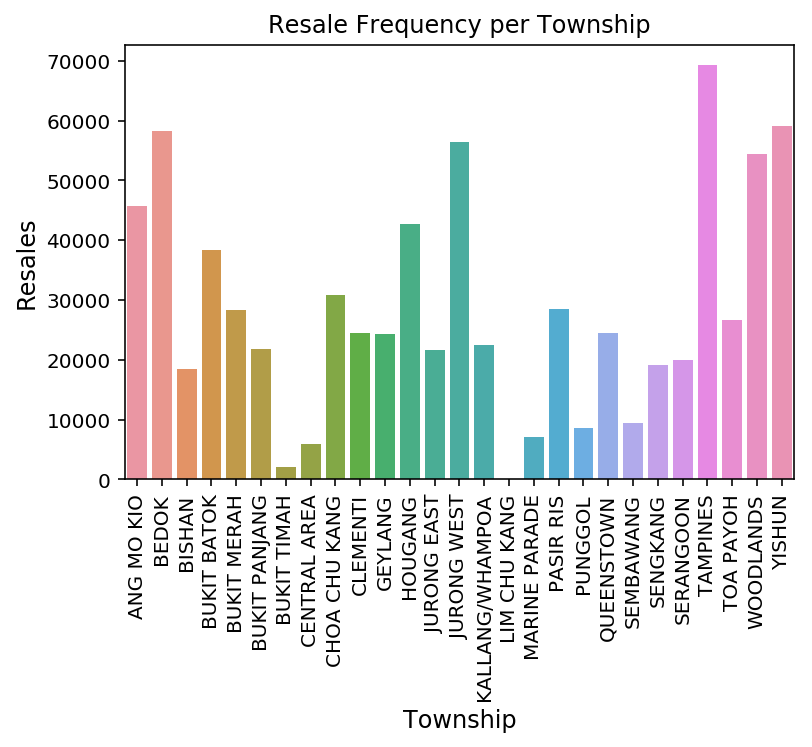

Town Count 
TAMPINES           69236
YISHUN             59020
BEDOK              58330
JURONG WEST        56447
WOODLANDS          54334
ANG MO KIO         45736
HOUGANG            42658
BUKIT BATOK        38291
CHOA CHU KANG      30913
PASIR RIS          28498
BUKIT MERAH        28376
TOA PAYOH          26724
QUEENSTOWN         24508
CLEMENTI           24504
GEYLANG            24400
KALLANG/WHAMPOA    22563
BUKIT PANJANG      21765
JURONG EAST        21570
SERANGOON          19989
SENGKANG           19095
BISHAN             18447
SEMBAWANG           9462
PUNGGOL             8596
MARINE PARADE       7070
CENTRAL AREA        5906
BUKIT TIMAH         2127
LIM CHU KANG          64
Name: town, dtype: int64


In [9]:
#town count
towns = np.unique(data['town'])
sns.countplot(x="town", data=data , order=towns)
plt.ylabel('Resales', fontsize=12)
plt.xlabel('Township', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Resale Frequency per Township", fontsize=12)
plt.show()
print("Town Count \n" +str(data['town'].value_counts()))

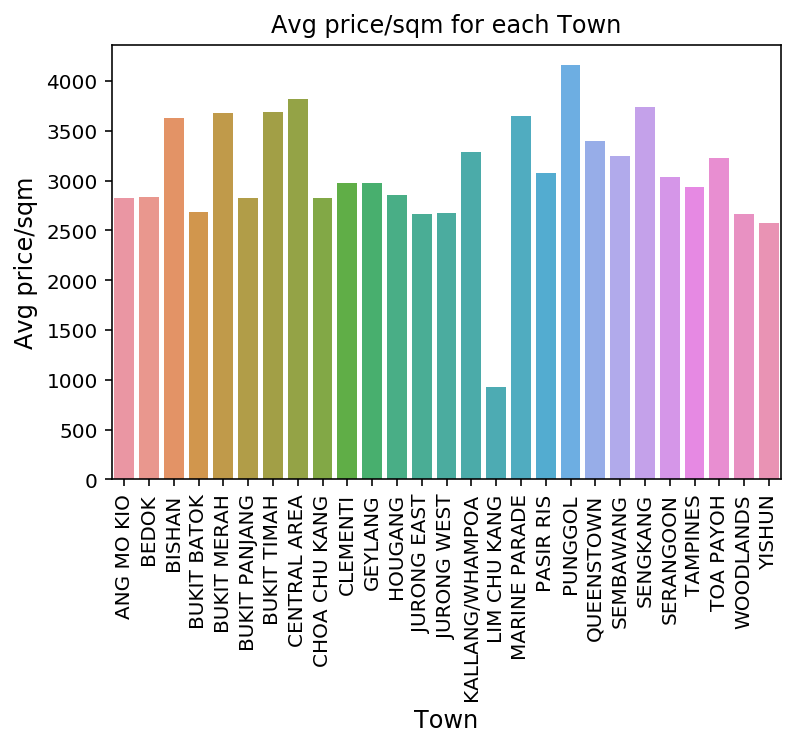

In [10]:
town_array = np.unique(data['town'])
n = data['town'].nunique()
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['town'] == town_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['town'] == town_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(town_array,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Town', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each Town", fontsize=12)
plt.show()

Observations:
- Besides Bukit Timah and Lim Chu Kang, all towns have more than 5000 sales occurrences.
- TAMPINES is the most present town, with 69236 sales.
- Lim Chu Kang is a clear outlier in terms of price/sqm. This is probably correlated to the low number of only 64 sales registered in that area.
- The most expensive town is Punggol.

#### 2.2.3 Flat_type

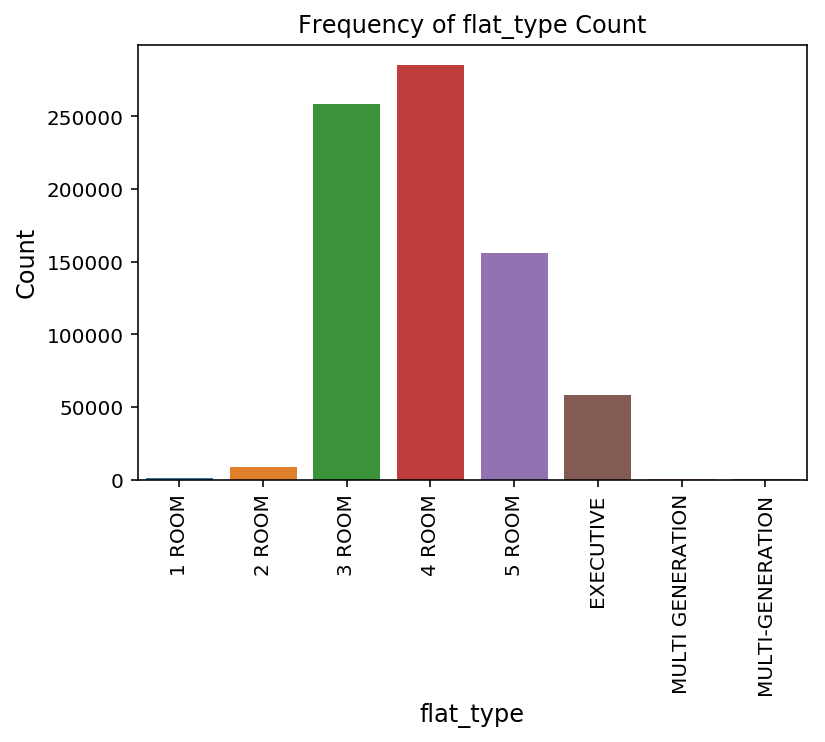

Flat Type Count 
4 ROOM              285136
3 ROOM              258482
5 ROOM              156260
EXECUTIVE            58177
2 ROOM                8859
1 ROOM                1246
MULTI GENERATION       279
MULTI-GENERATION       190
Name: flat_type, dtype: int64


In [11]:
#flat_type count
flat_type = np.unique(data['flat_type'])
sns.countplot(x="flat_type", data=data , order = flat_type)
plt.ylabel('Count', fontsize=12)
plt.xlabel('flat_type', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of flat_type Count", fontsize=12)
plt.show()
print("Flat Type Count \n" +str(data['flat_type'].value_counts()))

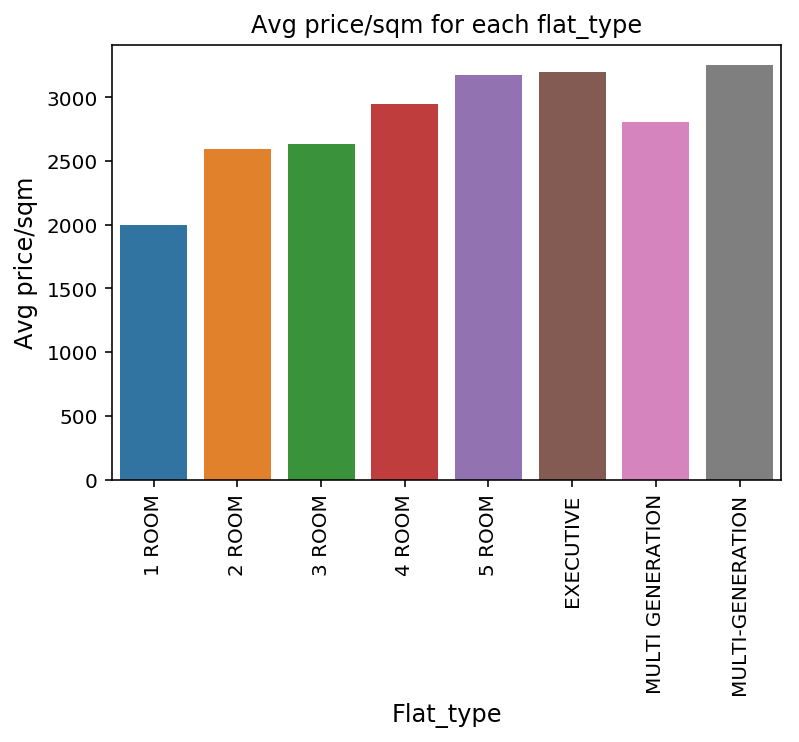

In [12]:
flat_type_array = np.unique(data['flat_type'])
n = data['flat_type'].nunique()
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['flat_type'] == flat_type_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['flat_type'] == flat_type_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(flat_type_array,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Flat_type', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each flat_type", fontsize=12)
plt.show()

Observations:
- 1 Room, 2 Room, and Multi-Generations are clearly fewer than the remaining flat types.
- The most common flat type is 4 rooms.
- Prices per sqm, surprisingly, seem to up with flat size.

#### 2.2.4 Flat_model

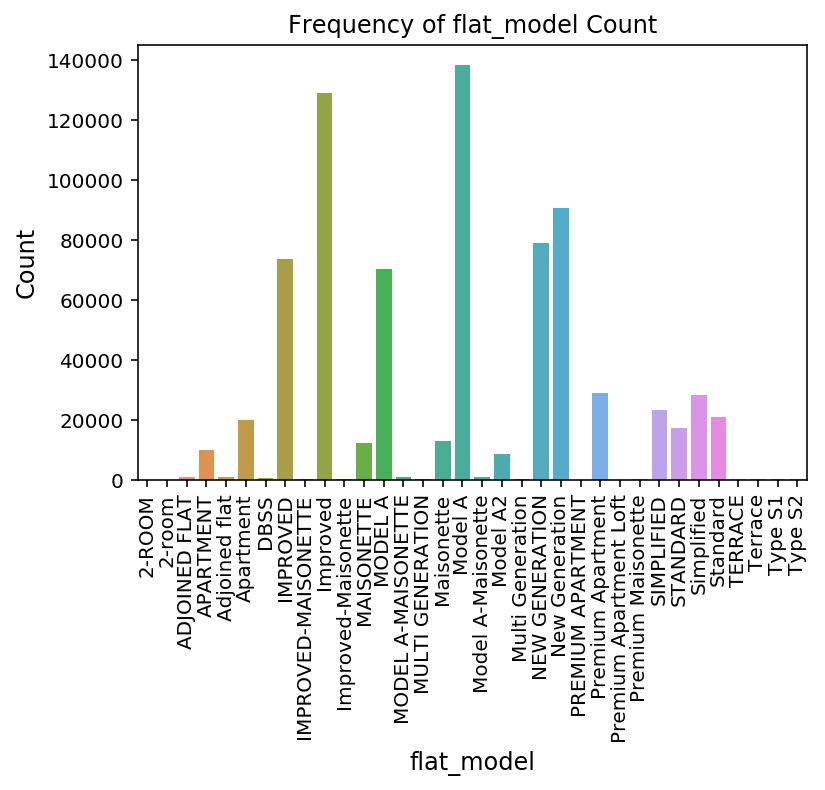

Flat Model Count 
Model A                   138252
Improved                  129009
New Generation             90745
NEW GENERATION             78898
IMPROVED                   73593
MODEL A                    70381
Premium Apartment          28880
Simplified                 28346
SIMPLIFIED                 23258
Standard                   20859
Apartment                  19745
STANDARD                   17375
Maisonette                 12921
MAISONETTE                 12215
APARTMENT                   9901
Model A2                    8382
MODEL A-MAISONETTE           982
Adjoined flat                969
ADJOINED FLAT                944
Model A-Maisonette           802
DBSS                         601
Terrace                      362
MULTI GENERATION             279
TERRACE                      247
Multi Generation             190
Type S1                      183
Type S2                       80
Premium Maisonette            75
Improved-Maisonette           61
IMPROVED-MAISONETTE      

In [13]:
#flat_model count
flat_model = np.unique(data['flat_model'])
sns.countplot(x="flat_model", data=data , order = flat_model)
plt.ylabel('Count', fontsize=12)
plt.xlabel('flat_model', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of flat_model Count", fontsize=12)
plt.show()
print("Flat Model Count \n" +str(data['flat_model'].value_counts()))

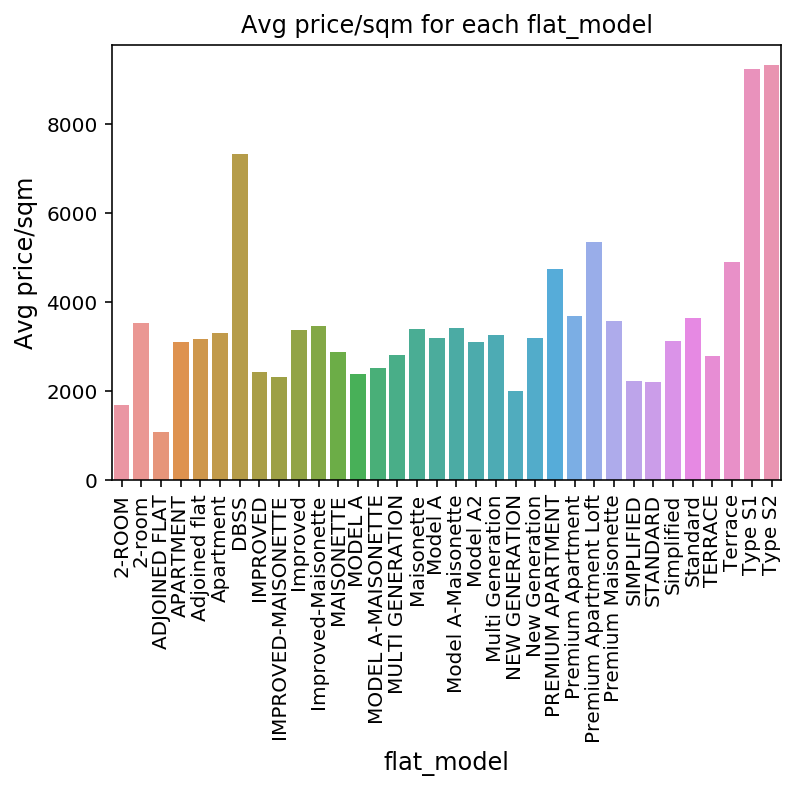

In [14]:
flat_model_array = np.unique(data['flat_model'])
n = data['flat_model'].nunique()
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['flat_model'] == flat_model_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['flat_model'] == flat_model_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(flat_model_array, avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('flat_model', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each flat_model", fontsize=12)
plt.show()

Obersvations:
- Concerning flat_models, there are lot of flat_models that exist less than a 1000 times.
- The most common ones are 'Model A' and 'Improved'.
- Prices/sqm vary widely, which is probably due to some sample sizes being very small.

#### 2.2.5 Lease commencement year

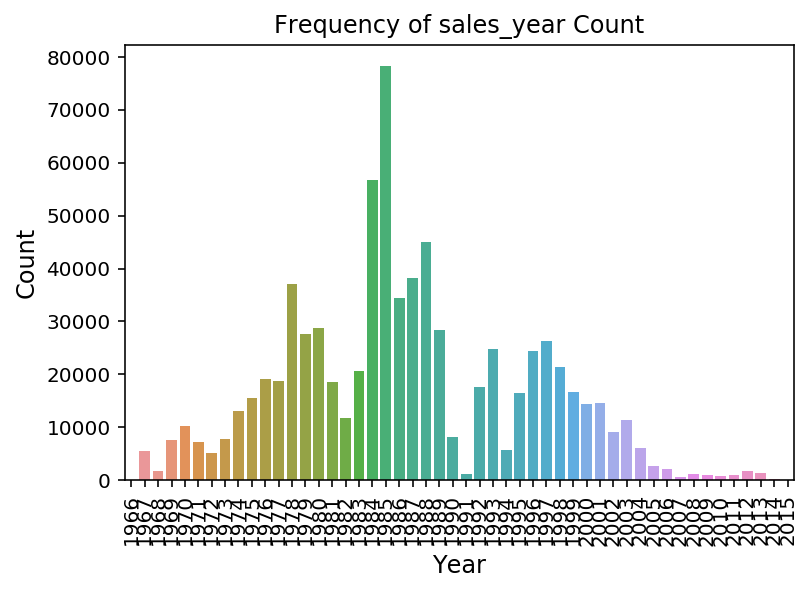

Total Sales Year Count: 50
Sales Year Count 
1985    78279
1984    56724
1988    45011
1987    38175
1978    37171
1986    34461
1980    28807
1989    28428
1979    27704
1997    26400
1993    24771
1996    24365
1998    21370
1983    20730
1976    19120
1977    18703
1981    18632
1992    17564
1999    16683
1995    16515
1975    15539
2001    14570
2000    14456
1974    13045
1982    11819
2003    11421
1970    10195
2002     9183
1990     8224
1973     7775
1969     7668
1971     7245
2004     6002
1994     5697
1967     5477
1972     5185
2005     2712
2006     2042
2012     1832
1968     1706
2013     1380
2008     1207
1991     1092
2011     1034
2009      998
2010      739
2007      583
2014      153
1966       21
2015       16
Name: lease_commence_date, dtype: int64


In [15]:
lease_year = np.unique(data['lease_commence_date'])
year_count_l = data['lease_commence_date'].value_counts()
sns.barplot(year_count_l.index, year_count_l.values, order=lease_year)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of sales_year Count", fontsize=12)
plt.show()

count_lease_year = data['lease_commence_date'].nunique()
print("Total Sales Year Count:", count_lease_year)
lease_year_count = data['lease_commence_date'].value_counts()
print("Sales Year Count \n" +str(lease_year_count))

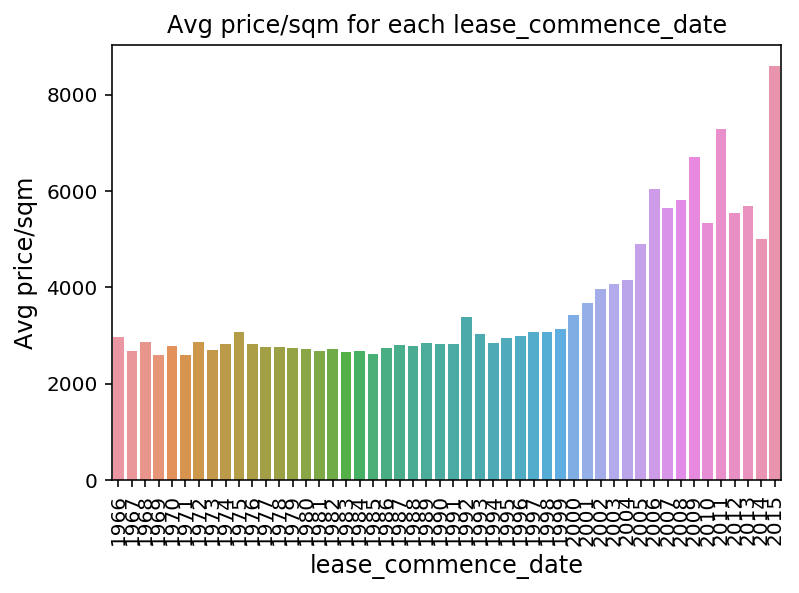

In [16]:
lease_commence_date_array = np.unique(data['lease_commence_date'])
n = data['lease_commence_date'].nunique()
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['lease_commence_date'] == lease_commence_date_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['lease_commence_date'] == lease_commence_date_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(lease_commence_date_array, avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('lease_commence_date', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each lease_commence_date", fontsize=12)
plt.show()

Observations:
- The years 1984-1990 have the most commencement dates. Before there is a ongoing increase and after an ongoing decrease.
- Prices/sqm remain relatively flat for commencement dates from 1966 to 2000 and increase from 2000 to 2012.

#### 2.2.6 Sales

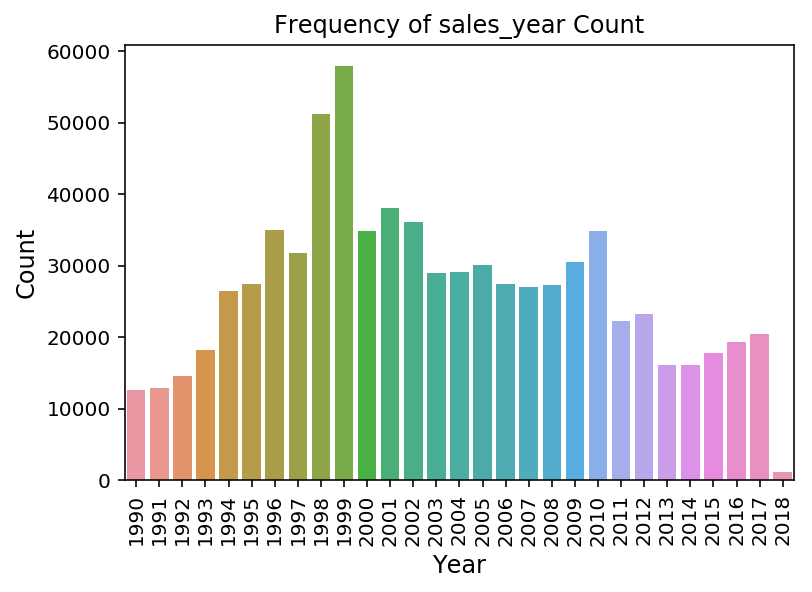

Sales Year Count 
1999    57906
1998    51201
2001    38055
2002    36098
1996    35014
2000    34862
2010    34854
1997    31815
2009    30482
2005    30045
2004    29112
2003    29003
2006    27427
1995    27368
2008    27262
2007    26982
1994    26474
2012    23198
2011    22281
2017    20390
2016    19373
1993    18193
2015    17780
2013    16097
2014    16096
1992    14607
1991    12954
1990    12612
2018     1088
Name: month, dtype: int64


In [17]:
#yearly sales trend
sales_year = np.unique(pd.DatetimeIndex(data['month']).year.values)
year_count=pd.DatetimeIndex(data['month']).year.value_counts()
sns.barplot(year_count.index, year_count.values, order=sales_year)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of sales_year Count", fontsize=12)
plt.show()
print("Sales Year Count \n" +str((pd.DatetimeIndex(data['month']).year).value_counts()))

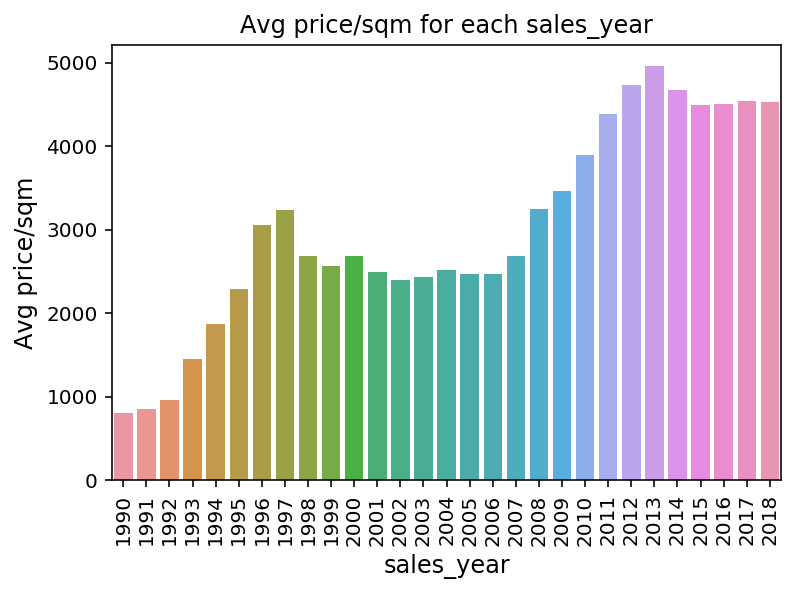

In [18]:
sales_year_array = np.unique(pd.DatetimeIndex(data['month']).year.values)
n = len(sales_year_array)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][pd.DatetimeIndex(data['month']).year.values == sales_year_array[i]].sum()
        sqmm = data['floor_area_sqm'][pd.DatetimeIndex(data['month']).year.values == sales_year_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(sales_year_array, avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('sales_year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each sales_year", fontsize=12)
plt.show()

Observations:
- Counts of Sales per year increase from 1990 to 1999 and decrease thereafter.
- As expected, in general, prices per sqm increase over time.
- However there was a dip after 1997 and after 2013.

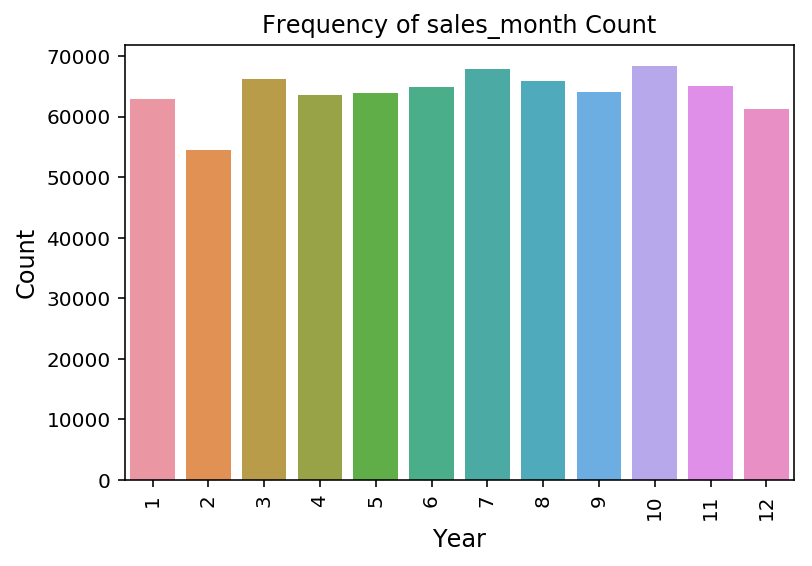

Sales Month Count 
10    68395
7     67944
3     66163
8     65883
11    65118
6     64940
9     64071
5     63941
4     63497
1     62865
12    61241
2     54571
Name: month, dtype: int64


In [19]:
#monthly sales trend
sales_month = np.unique(pd.DatetimeIndex(data['month']).month.values)
year_count=pd.DatetimeIndex(data['month']).month.value_counts()

sns.barplot(year_count.index, year_count.values, order=sales_month)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of sales_month Count", fontsize=12)
plt.show()
print("Sales Month Count \n" +str((pd.DatetimeIndex(data['month']).month).value_counts()))

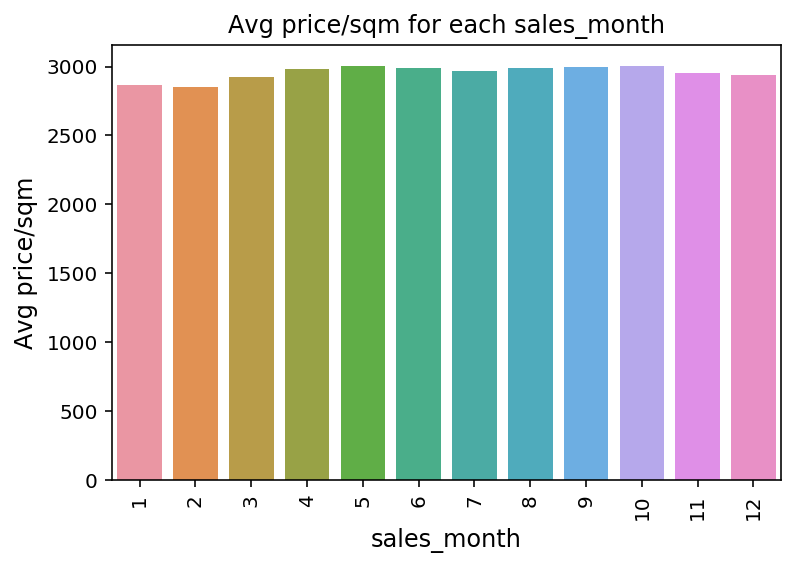

In [20]:
month_year_array = np.unique(pd.DatetimeIndex(data['month']).month.values)
n = len(month_year_array)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][pd.DatetimeIndex(data['month']).month.values == month_year_array[i]].sum()
        sqmm = data['floor_area_sqm'][pd.DatetimeIndex(data['month']).month.values == month_year_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

sns.barplot(month_year_array, avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('sales_month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each sales_month", fontsize=12)
plt.show()

Observations:
- It seems like the last and first month of a year have slightly lower prices than the middle months.

#### 2.2.7 SQM

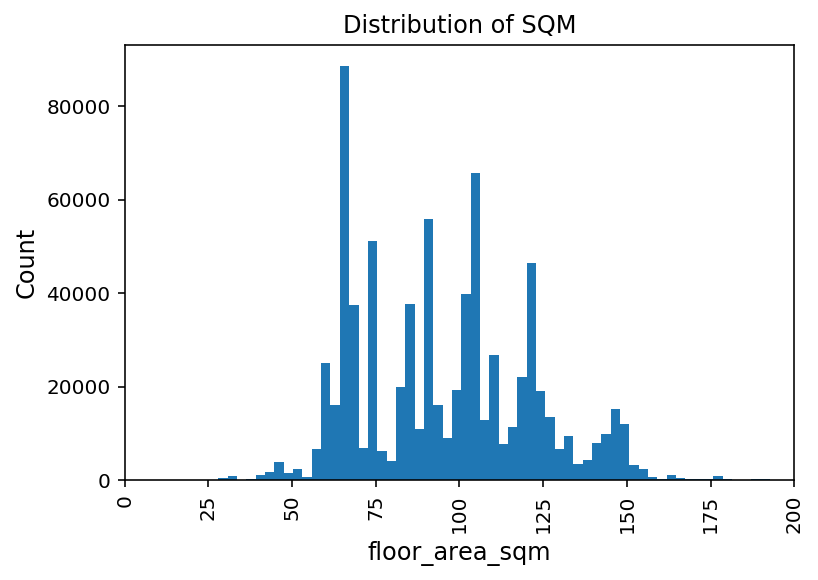

In [21]:
# SQM distribution
plt.hist(data['floor_area_sqm'], bins=100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor_area_sqm', fontsize=12)
plt.xticks(rotation='vertical')
plt.xlim(0,200)
plt.title("Distribution of SQM", fontsize=12)
plt.show()

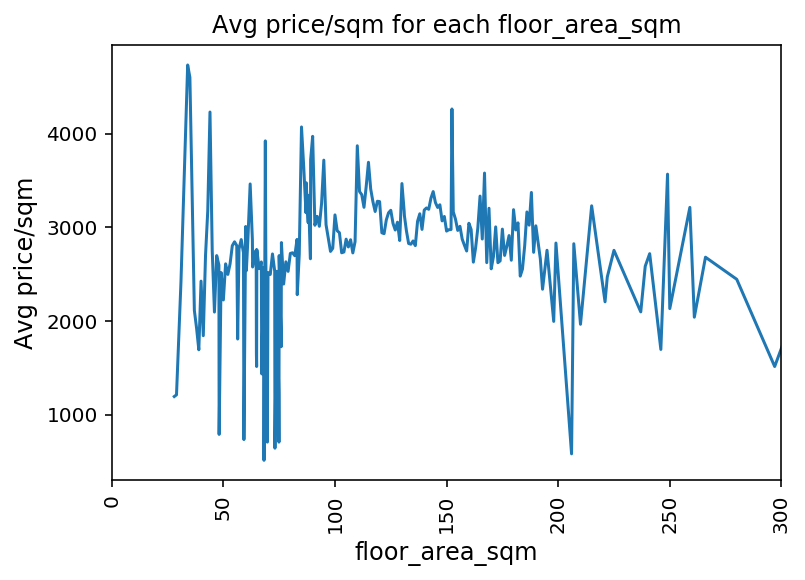

In [22]:
sqm_array = np.unique(data['floor_area_sqm'])
n = len(sqm_array)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['floor_area_sqm'] == sqm_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['floor_area_sqm'] == sqm_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM

plt.plot(sqm_array, avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('floor_area_sqm', fontsize=12)
plt.xticks(rotation='vertical')
plt.xlim(0,300)
plt.title("Avg price/sqm for each floor_area_sqm", fontsize=12)
plt.show()

Observations:
- We can see that the largest chunk of the HBDs are between 25 and 200 sqm.
- There are strong variations of counts between the different bins.
- Prices per sqm seem to be highest in the mid-range of SQM.

#### 2.2.8 Storey

In [25]:
sns.countplot(x="storey_range", data=data, order=storey_array)
plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of storey_range Count", fontsize=12)
plt.show()

NameError: name 'storey_array' is not defined

In [ ]:
storey_array = np.unique(data['storey_range'])
n = len(storey_array)
avg_price = np.zeros(n)

for i in range(0,n):
        price = data['resale_price'][data['storey_range'] == storey_array[i]].sum()
        sqmm = data['floor_area_sqm'][data['storey_range'] == storey_array[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(storey_array,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Storey', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Avg price/sqm for each storey", fontsize=12)
plt.show()

Observations:
- There is a clear upwards trend in prices for higher stories.
- There are few storey ranges that spike in price.
- Those ranges also tend to have really low frequency.
- These ranges also tend to be included in other ranges.
- It is possible that e.g. in recent years, which have higher prices, the storey format changed; which would explain higher avg. prices per sqm.

#### 2.2.9 Output (price)

In [ ]:
# Price distribution
plt.hist(data['resale_price'], bins=100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('resale_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribution of resale_price", fontsize=12)
plt.show()

plt.hist(data['resale_price'], bins=100)
plt.ylabel('Count', fontsize=12)
plt.xlabel('resale_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.ylim(0,5000)
plt.xlim(0,20000)
plt.title("Distribution of resale_price", fontsize=12)
plt.show()

Observations:
- Practically no prices per flat go above 1,000,000 SGD.
- The majority of prices are betwenn 150,000 and 400,000 SGD.
- There seems to be a number of flats (400+) that were sold for less than 10,000 SGD.

### Creating longitude latitude

In [48]:
# Create a new code

g = geocoder.tgos("Raffles Place")

print(g)

#print(g.osm['x'])
#print(g.osm['y'])

#transform = geocoder.geonames(data['street_name'][1],key="jeff10901",method="details")
#transform = geocoder.geonames(data['street_name'],key="jeff10901")

#data['lat'] = g.tomtom['x']
#data['long'] = g.tomt['y']


<[Unknown] Tgos - Geocode [empty]>


In [43]:
data.head()

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town,lat_long,lat,long
0,309,IMPROVED,1 ROOM,31.0,1977,1990-01,NaN,9000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO,None,None,None
1,309,IMPROVED,1 ROOM,31.0,1977,1990-01,NaN,6000.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,None,None,None
2,309,IMPROVED,1 ROOM,31.0,1977,1990-01,NaN,8000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO,None,None,None
3,309,IMPROVED,1 ROOM,31.0,1977,1990-01,NaN,6000.0,07 TO 09,ANG MO KIO AVE 1,ANG MO KIO,None,None,None
4,216,NEW GENERATION,3 ROOM,73.0,1976,1990-01,NaN,47200.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO,None,None,None


## 3 Cleaning and Preprocessing the Dataset
<hr>
After exploring the dataset, we came across the following points for preprocessing the data: 
- The feature month consists of sales year and month, e.g. 1990-01. To include the variable in the model, this variable will be seperated to a variable called sales year and a variable called month. 
- However, a linear regression will not be able to read the years, since it can see it as another numerical value. Therefore, the remaining lease year is calculated. Once the sales year variable is created, the remaining lease year can be computed by using the following formula: $remaining lease year = 99 - (sales year - lease commence date)$.
- Furthermore, there are rows containing characters. These rows (town, flat type, flat model and storey range) are transformed into dummy variables to clarify their levels, with other words, to quantify the qualitative data. <br>

### 3.1 Feature Engineering
In this part, we will explore new features that we can add to make our data more valuable.

### 3.2 Variables

The variables considered in the research will be: <br>
$x_1$ Remaining lease year <br>
$x_2$ Floor area squared meters <br>
$D_3$ Town and/or Area <br>
$D_4$ Flat type <br>
$D_5$ Flat model <br>
$D_6$ Storey range <br>
$x_7$ Month <br>
$Y$ Resale price <br>

## 4 Data Analysis
<hr>
This part of the report will show algorithms that have been applied to predict the housing prices. We have focused on regressions with different features. <br>

### 4.1 Linear Regression
Predictive model with linear regression

### 4.2 Error Analysis 
To perform the error analysis, the accuracy are considered to 

### 4.3 Cross Validation
To check whether the data is overfitting 

https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

## 5 Results
<hr>
Based on the analysis, the following results are derived:

## 6 Conclusion
<hr>
From this research, we can conclude